***
## notebook config

In [1]:
ON_COLAB = False

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade tsforest > /dev/null 2>&1
    !pip install --upgrade lightgbm > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
else:
    input_path = "../data"
    print("input_path:", input_path)

input_path: ../data


***

In [4]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import stats
import time

import category_encoders as ce
import lightgbm as lgb
from tqdm import tqdm
from tsforest.forecast import LightGBMForecaster
import optuna

pd.set_option('display.max_columns', None)

/Users/mavillan/miniconda3/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
def reduce_mem_usage(df, verbose=False):
    """
    Utility function to reduce the memory usage of pandas dataframes
    
    Parameters
    ----------
    df: pandas.Dataframe
    verbose: Boolean
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
class RMSSE():
    def __init__(self, valid_dataframe, scales_dataframe):
        self.valid_dataframe = valid_dataframe
        self.scales_dataframe = scales_dataframe
        self.apply_inverse = False
        if set(["y_mean","y_std"]) <= set(valid_dataframe.columns):
            self.apply_inverse = True

    def _evaluate(self, predictions):
        valid_dataframe = self.valid_dataframe.copy()
        if not self.apply_inverse:  
            valid_dataframe["ypred"] = predictions
            valid_dataframe["sq_error"] = valid_dataframe.eval("(y-ypred)**2")
        else:
            valid_dataframe["ypred"] = valid_dataframe["y_std"]*predictions + valid_dataframe["y_mean"]
            valid_dataframe["sq_error"] = valid_dataframe.eval("(y_raw-ypred)**2")
        mse = valid_dataframe.groupby("sku")["sq_error"].mean().reset_index(name="mse")
        mrg = pd.merge(mse, self.scales_dataframe, how="inner", on="sku")
        return mrg.eval("sqrt(mse)/scale").mean()

    def evaluate(self, ypred, dtrain):
        metric = self._evaluate(ypred)
        return "rmsse", metric, False

In [7]:
def ranked_probability_score(y_true, y_pred):
    """
    Input
        y_true: np.array of shape 30. 
        y_pred: np.array of shape 30. 
    """
    return ((y_true.cumsum(axis=1) - y_pred.cumsum(axis=1))**2).sum(axis=1).mean()

def scoring_function(y_true, y_pred):
    """
    Input
        y_true: List of Ints of shape Nx1. Contain the target_stock
        y_pred: List of float of shape Nx30. Contain the prob for each day
    """
    y_true_one_hot = np.zeros_like(y_pred, dtype=np.float64)
    y_true_one_hot[range(len(y_true)), y_true-1] = 1
    return ranked_probability_score(y_true_one_hot, y_pred)

***
## loading data for assessment

In [8]:
scales = pd.read_csv(f"{input_path}/scales.csv")
skus_for_assess = pd.read_csv(f"{input_path}/skus_for_assess.csv")

dataset = (
    pd.read_parquet(f"{input_path}/train.parquet")
    .query("sku in @skus_for_assess.sku")
    .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
    .reset_index(drop=True)
)
dataset

,ds,sku,y,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,available,item_domain_id,item_id,site_id,product_id,product_family_id
0,2021-02-01,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
1,2021-02-02,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
2,2021-02-03,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
3,2021-02-04,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
4,2021-02-05,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29179486,2021-03-27,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.0,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
29179487,2021-03-28,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.0,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
29179488,2021-03-29,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.0,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
29179489,2021-03-30,660915,0,99.989998,MEX,classic,fulfillment,paid_shipping,0.0,1,MLM-SURGICAL_MASKS,423179,MLM,None,None


In [9]:
dataset.groupby("site_id")["sku"].nunique()

site_id
MLA     43314
MLB    252475
MLM    201008
Name: sku, dtype: int64

***
## model config

In [10]:
categorical_features = {
    "sku": ("y", ce.CatBoostEncoder, None),
    "currency": "default",
    "listing_type": "default",
    "shipping_logistic_type": "default",
    "shipping_payment": "default",
    "item_domain_id": "default",
    "item_id": ("y", ce.CatBoostEncoder, None),
    "site_id":"default",
    "product_id": ("y", ce.CatBoostEncoder, None),
    "product_family_id": ("y", ce.CatBoostEncoder, None),
}

exclude_features = ["fold","sold_quantity",]

model_params = {
    'objective':'tweedie',
    'tweedie_variance_power':1.6,
    'metric':'None',
    'num_iterations':1000,
    'max_bin': 63,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 2**8-1,
    'min_data_in_leaf': 2**8-1,
    'learning_rate': 0.02,
    'max_delta_step':1.,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'boost_from_average': False,
    'force_row_wise': True,
    'deterministic':True,
    'seed':42,
    #'device_type': 'gpu',
    #'num_gpu' : 1,
}
time_features = [
    "week_day",
    "week_day_cos",
    "week_day_sin",
    "month_progress",
]
model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["sku",],
}

In [11]:
dataset.loc[:,categorical_features.keys()].isna().sum(axis=0) / len(dataset)

sku                       0.000000
currency                  0.000000
listing_type              0.000000
shipping_logistic_type    0.000000
shipping_payment          0.000000
item_domain_id            0.000000
item_id                   0.000000
site_id                   0.000000
product_id                0.963178
product_family_id         0.883613
dtype: float64

In [12]:
dataset.loc[:,categorical_features.keys()].nunique()

sku                       496797
currency                       4
listing_type                   2
shipping_logistic_type         3
shipping_payment               2
item_domain_id              8156
item_id                   392139
site_id                        3
product_id                 11756
product_family_id          24176
dtype: int64

***
## model training: assessment

In [13]:
models_by_site = list()
sites = ["MLA","MLB","MLM"]

for site in sites:
    print("-"*75)
    print(f"Preparing model for site: {site}")

    tic = time.time()
    train_data = dataset.query("site_id == @site").reset_index(drop=True)
    valid_idx = train_data.query("ds > '2021-03-01'").index

    model = LightGBMForecaster(**model_kwargs)
    model.prepare_features(train_data, valid_idx)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
    model.fit(fit_kwargs={"verbose_eval":50, "feval":evaluator.evaluate})
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")

errors = list()
sites = ["MLA","MLB","MLM"]
for site,model in zip(sites,models_by_site):
    error = model.model.model.best_score["valid_0"]["rmsse"]
    errors.append(error)
result = {
    "rmsse_MLA":errors[0], 
    "rmsse_MLB":errors[1],
    "rmsse_MLM":errors[2],
    "rmsse_AVG":np.mean(errors),
}
display(result)

---------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 81.74 Mb (52.4% reduction)
Mem. usage decreased to 85.51 Mb (52.4% reduction)
Elapsed time for processing features: 0.26339162985483805 min.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 1242194, number of used features: 14
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.819609
[100]	valid_0's rmsse: 0.775299
[150]	valid_0's rmsse: 0.769374
Early stopping, best iteration is:
[161]	valid_0's rmsse: 0.769179
Elapsed time for training the model: 1.048792584737142 min.
---------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 478.48 Mb (52.4% reduction)
Mem. usage decreased to 498.41 Mb (52.4% reduction)
Elapsed time for processing features: 1.4729249159495035 min.
[LightGBM] [Info] Total Bins 2674
[LightGBM] 

{'rmsse_MLA': 0.7691791278825674,
 'rmsse_MLB': 0.8119939992312364,
 'rmsse_MLM': 0.7675033759264847,
 'rmsse_AVG': 0.7828921676800961}

In [14]:
%%time
all_preds = list()
for site,model in zip(sites,models_by_site):
    preds = model.predict(dataset.query("site_id==@site & ds<='2021-03-01'"))
    all_preds.append(preds)
train_preds = pd.concat(all_preds, axis=0, ignore_index=True)

CPU times: user 10min 5s, sys: 19.9 s, total: 10min 25s
Wall time: 1min 46s


In [15]:
%%time
all_preds = list()
for site,model in zip(sites,models_by_site):
    preds = model.predict(dataset.query("site_id==@site & ds>'2021-03-01'"))
    all_preds.append(preds)
oof = pd.concat(all_preds, axis=0, ignore_index=True)

CPU times: user 10min 27s, sys: 17.7 s, total: 10min 45s
Wall time: 1min 45s


In [16]:
train_preds = pd.merge(train_preds, dataset.loc[:,["ds","sku","y"]], how="inner", on=["ds","sku"])
train_preds["sq_error"] = train_preds.eval("(y-y_pred)**2")
train_errors = np.sqrt(train_preds.groupby("sku")["sq_error"].mean()).reset_index(name="rmse")
train_errors = pd.merge(train_errors, scales, how="inner", on="sku")
train_errors["rmsse"] = train_errors.eval("rmse/scale")
train_errors = train_errors.set_index("sku")
train_errors

,rmse,scale,rmsse
sku,,,
1,0.496732,1.025536,0.484363
3,0.418272,0.508548,0.822483
4,2.053692,2.463527,0.833639
5,0.164394,0.694808,0.236604
6,0.848865,1.050451,0.808095
...,...,...,...
660911,0.476847,0.830455,0.574200
660912,0.769898,1.033908,0.744649
660913,0.177279,0.587220,0.301895


In [63]:
class InventoryDaysPredictor():

    def __init__(self, train, train_errors):
        self.train = train.copy(deep=True)
        self.train_errors = train_errors.copy(deep=True)

    def fit(self, preds):
        parameters = self.train.groupby('sku').agg({'y':['mean', 'std']}).y
        # replace nan means by overall mean
        idx = parameters[parameters["mean"].isna()].index 
        parameters.loc[idx, "mean"] = parameters["mean"].mean()
        # replace nan stds by overall std
        idx = parameters[parameters["std"].isna()].index
        parameters.loc[idx,"std"] = parameters["std"].mean()
        self.parameters = parameters.to_dict()

        predictors = dict()
        days = np.arange(1,31)
        for sku,df in tqdm(preds.groupby("sku")):
            cumpred = df.y_pred.values.cumsum()
            interp = interpolate.interp1d(cumpred, days, bounds_error=False, fill_value=(-np.inf,np.inf))
            predictors[sku] = interp
        self.predictors = predictors

    def predict(self, sku, stock):
        mean = self.parameters['mean'][sku]
        std = self.parameters['std'][sku]
        days_to_stockout = float(np.clip(self.predictors[sku](stock), a_min=1, a_max=30))
        std_days = std/mean
        return days_to_stockout,std_days

    def predict_proba(self, sku, stock, dist_kwargs, lambda1, lambda2):
        days_to_stockout,std_days = self.predict(sku, stock)
        scale = std_days * (lambda1*(days_to_stockout**lambda2))
        days = np.arange(1,31)
        probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, **dist_kwargs)
        #if prob is zero, replace with uniform
        if np.sum(probs) == 0:
            return np.ones(30) / 30
        return probs/np.sum(probs)

In [64]:
predictor = InventoryDaysPredictor(dataset.query("ds <= '2021-03-01'"), train_errors)
predictor.fit(oof)

100%|██████████| 496797/496797 [01:07<00:00, 7400.45it/s]


***
## tuning of distribution parameters

In [69]:
valid = pd.read_csv(f"{input_path}/validation_seed2.csv")

def objective(trial):
    beta = trial.suggest_uniform("beta", 0.1, 5)
    lambda1 = trial.suggest_uniform("lambda1", 0.1, 2.)
    lambda2 = trial.suggest_uniform("lambda2", 0.5, 2.)
    
    preds_proba = list()
    for sku,df in valid.groupby("sku"):
        preds_proba.append(predictor.predict_proba(
            sku, 
            stock=df.target_stock.values[0],
            dist_kwargs={"beta":beta},
            lambda1=lambda1, 
            lambda2=lambda2,
        ))
    preds_proba = np.array(preds_proba)
    
    rps = scoring_function(valid.inventory_days.values, preds_proba)
    return rps

In [70]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10000, timeout=28800, n_jobs=1) # 8hrs

[I 2021-08-18 00:02:21,254] A new study created in memory with name: no-name-0af4a084-5bd4-406e-9a61-5f7f2d6f7c75
[I 2021-08-18 00:05:01,304] Trial 0 finished with value: 4.293809917290444 and parameters: {'beta': 3.3521364387676913, 'lambda1': 1.981725616315302, 'lambda2': 1.0762022967989018}. Best is trial 0 with value: 4.293809917290444.
[I 2021-08-18 00:08:05,837] Trial 1 finished with value: 4.258800163996865 and parameters: {'beta': 2.416691008169078, 'lambda1': 1.534580790731213, 'lambda2': 1.1839498621909357}. Best is trial 1 with value: 4.258800163996865.
[I 2021-08-18 00:11:08,038] Trial 2 finished with value: 4.3645784180344736 and parameters: {'beta': 3.8160803062641713, 'lambda1': 0.7246249035996762, 'lambda2': 1.8888349489224907}. Best is trial 1 with value: 4.258800163996865.
[I 2021-08-18 00:14:23,346] Trial 3 finished with value: 4.806548511490178 and parameters: {'beta': 4.221957011011593, 'lambda1': 0.9024744710230926, 'lambda2': 0.5347172573742296}. Best is trial 1 

In [71]:
study.trials_dataframe().sort_values("value").head(20)

,number,value,datetime_start,datetime_complete,duration,params_beta,params_lambda1,params_lambda2,state
184,184,3.979701,2021-08-18 07:19:29.608386,2021-08-18 07:21:36.985511,0 days 00:02:07.377125,0.775446,0.760338,0.822246,COMPLETE
189,189,3.979808,2021-08-18 07:30:06.680325,2021-08-18 07:32:14.848455,0 days 00:02:08.168130,0.789202,0.821501,0.808018,COMPLETE
185,185,3.979812,2021-08-18 07:21:36.987882,2021-08-18 07:23:44.767859,0 days 00:02:07.779977,0.785679,0.835548,0.812698,COMPLETE
200,200,3.979895,2021-08-18 07:53:26.808766,2021-08-18 07:55:34.185284,0 days 00:02:07.376518,0.730878,0.794692,0.788386,COMPLETE
186,186,3.979971,2021-08-18 07:23:44.770825,2021-08-18 07:25:52.146531,0 days 00:02:07.375706,0.778886,0.756293,0.821107,COMPLETE
183,183,3.980365,2021-08-18 07:17:22.430236,2021-08-18 07:19:29.605691,0 days 00:02:07.175455,0.813176,0.860827,0.811434,COMPLETE
182,182,3.980449,2021-08-18 07:15:15.314395,2021-08-18 07:17:22.427542,0 days 00:02:07.113147,0.804471,0.860983,0.787172,COMPLETE
201,201,3.980768,2021-08-18 07:55:34.187737,2021-08-18 07:57:41.488226,0 days 00:02:07.300489,0.693286,0.773101,0.780660,COMPLETE
171,171,3.980926,2021-08-18 06:51:50.821197,2021-08-18 06:53:58.593132,0 days 00:02:07.771935,0.835911,0.891691,0.804034,COMPLETE
202,202,3.981063,2021-08-18 07:57:41.490754,2021-08-18 07:59:48.907889,0 days 00:02:07.417135,0.696615,0.773702,0.773935,COMPLETE


In [66]:
preds_proba = list()
for sku,df in valid.groupby("sku"):
    preds_proba.append(predictor.predict_proba(
        sku, 
        stock=df.target_stock.values[0],
        dist_kwargs={"beta":2},
        lambda1=1, 
        lambda2=1,
    ))
preds_proba = np.array(preds_proba)

rps = scoring_function(valid.inventory_days.values, preds_proba)
rps

4.096013023350327

***
## Assessment of invetory days prediction

In [22]:
valid = pd.read_csv(f"{input_path}/validation_seed2.csv")

preds = list()
for sku,df in tqdm(valid.groupby("sku")):
    preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
preds = pd.DataFrame(preds, columns=["days_to_stockout"])

100%|██████████| 496797/496797 [02:40<00:00, 3090.53it/s]


RMSE (mean):  10.592463505234754
RMSE (median):  6.0
MAE (mean):  7.955064098778316
MAE (median):  6.0


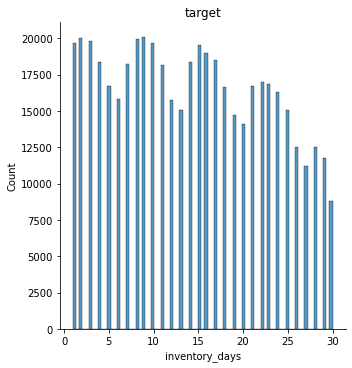

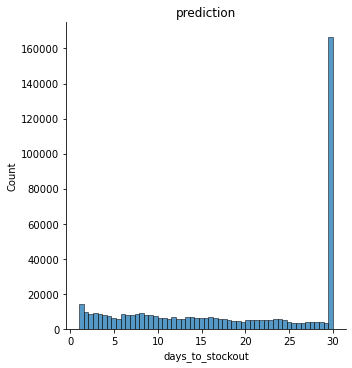

In [23]:
print("RMSE (mean): ", np.sqrt(np.mean((preds.days_to_stockout - valid.inventory_days)**2)) )
print("RMSE (median): ", np.sqrt(np.median((preds.days_to_stockout - valid.inventory_days)**2)) )
print("MAE (mean): ", np.mean(np.abs(preds.days_to_stockout - valid.inventory_days)))
print("MAE (median): ", np.median(np.abs(preds.days_to_stockout - valid.inventory_days)))

sns.displot(valid.inventory_days)
plt.title("target")
plt.show()

sns.displot(preds.days_to_stockout)
plt.title("prediction")
plt.show()

***
## Assessment of RPS

In [29]:
results = list()

for files in glob("./validation_seed*.csv")[:3]:
    valid = pd.read_csv(files)

    preds_proba = list()
    for sku,df in tqdm(valid.groupby("sku")):
        preds_proba.append(predictor.predict_proba(sku, df.target_stock.values[0]))
    preds_proba = np.array(preds_proba)
    
    rps = scoring_function(valid.inventory_days.values, preds_proba)
    results.append({"file":files.split("/")[-1].split(".")[0], "rps":rps})
    print({"file":files.split("/")[-1].split(".")[0], "rps":rps})

100%|██████████| 496797/496797 [09:35<00:00, 863.37it/s]


{'file': 'validation_seed17', 'rps': 4.144744792191483}


100%|██████████| 496797/496797 [09:29<00:00, 872.56it/s]


{'file': 'validation_seed19', 'rps': 4.137523467669764}


100%|██████████| 496797/496797 [09:29<00:00, 871.91it/s]


{'file': 'validation_seed2', 'rps': 4.140724628030401}


In [30]:
pd.DataFrame(results)

,file,rps
0,validation_seed17,4.144745
1,validation_seed19,4.137523
2,validation_seed2,4.140725


***